In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat

In this notebook we will explore the concept of synergy in EMG recording. We will be working with high density sEMG dataset.

Let's start with the basic loading and preprocessing. Install gdown and download file if you haven't.

In [2]:
# !pip install gdown

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.0 MB/s eta 0:00:00
  Using cached charset_normalizer-3.3.2-cp311-cp311-win_amd64.whl.metadata (34 kB)
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/162.5 kB ? eta -:--:--
   --------------------------------------- 162.5/162.5 kB 10.2 MB/s eta 0:00:00
Using cached charset_normalizer-3.3.2-cp311-cp311-win_amd64.whl (99 kB)
   ---------------------------------------- 0.0/104.6 kB ? eta -:--:--
   ---------------------------------------- 104.6/104.6 kB 5.9 MB/s eta 0:00:00
Using cached requests-2.31.0-py3-none-any.whl (62 kB)


In [3]:
# import gdown
# url = "https://drive.google.com/uc?id=1Y8Zsm3e2KhElaQbcKykUURS65a3ce27g"
# output = "subj1_relevant_vars.mat"
# gdown.download(url, output, quiet = False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Y8Zsm3e2KhElaQbcKykUURS65a3ce27g
From (redirected): https://drive.google.com/uc?id=1Y8Zsm3e2KhElaQbcKykUURS65a3ce27g&confirm=t&uuid=b55366c6-fcc2-4f4b-a008-cfcab146780a
To: h:\Shared drives\NX-421-TNE\Week 12\subj1_relevant_vars.mat
100%|██████████| 1.48G/1.48G [00:40<00:00, 36.9MB/s]


'subj1_relevant_vars.mat'

In [4]:
data = loadmat("subj1_relevant_vars.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])

In [5]:
emg_data = data["emg_flexors_new"]
print(emg_data.shape)

emg_data = emg_data.reshape(emg_data.shape[0], 64) # reshape to 64 channels
fs = data["Fs"][0, 0] # sampling frequency


(3000000, 8, 8)


In [6]:
from scipy.signal import butter
from scipy.signal import sosfiltfilt
import time


sos = butter(N=4, fs=fs, Wn=(5, 500), btype="bandpass", output="sos")
t = time.time()
emg_filtered = sosfiltfilt(sos, emg_data)
print("Elapsed time: ", time.time() - t)

Elapsed time:  8.389032363891602


In [7]:
from scipy.ndimage import convolve1d
# Easier method to compute the envelope 

emg_subsampled = emg_filtered[::2, :] # subsample by steps of 2 to reduce data size for easier computation
emg_rectified = emg_subsampled ** 2 # rectify the signal. We could also use abs

weights = np.ones(200)
t = time.time()
emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
print("Elapsed time: ", time.time() - t)

Elapsed time:  17.223154067993164


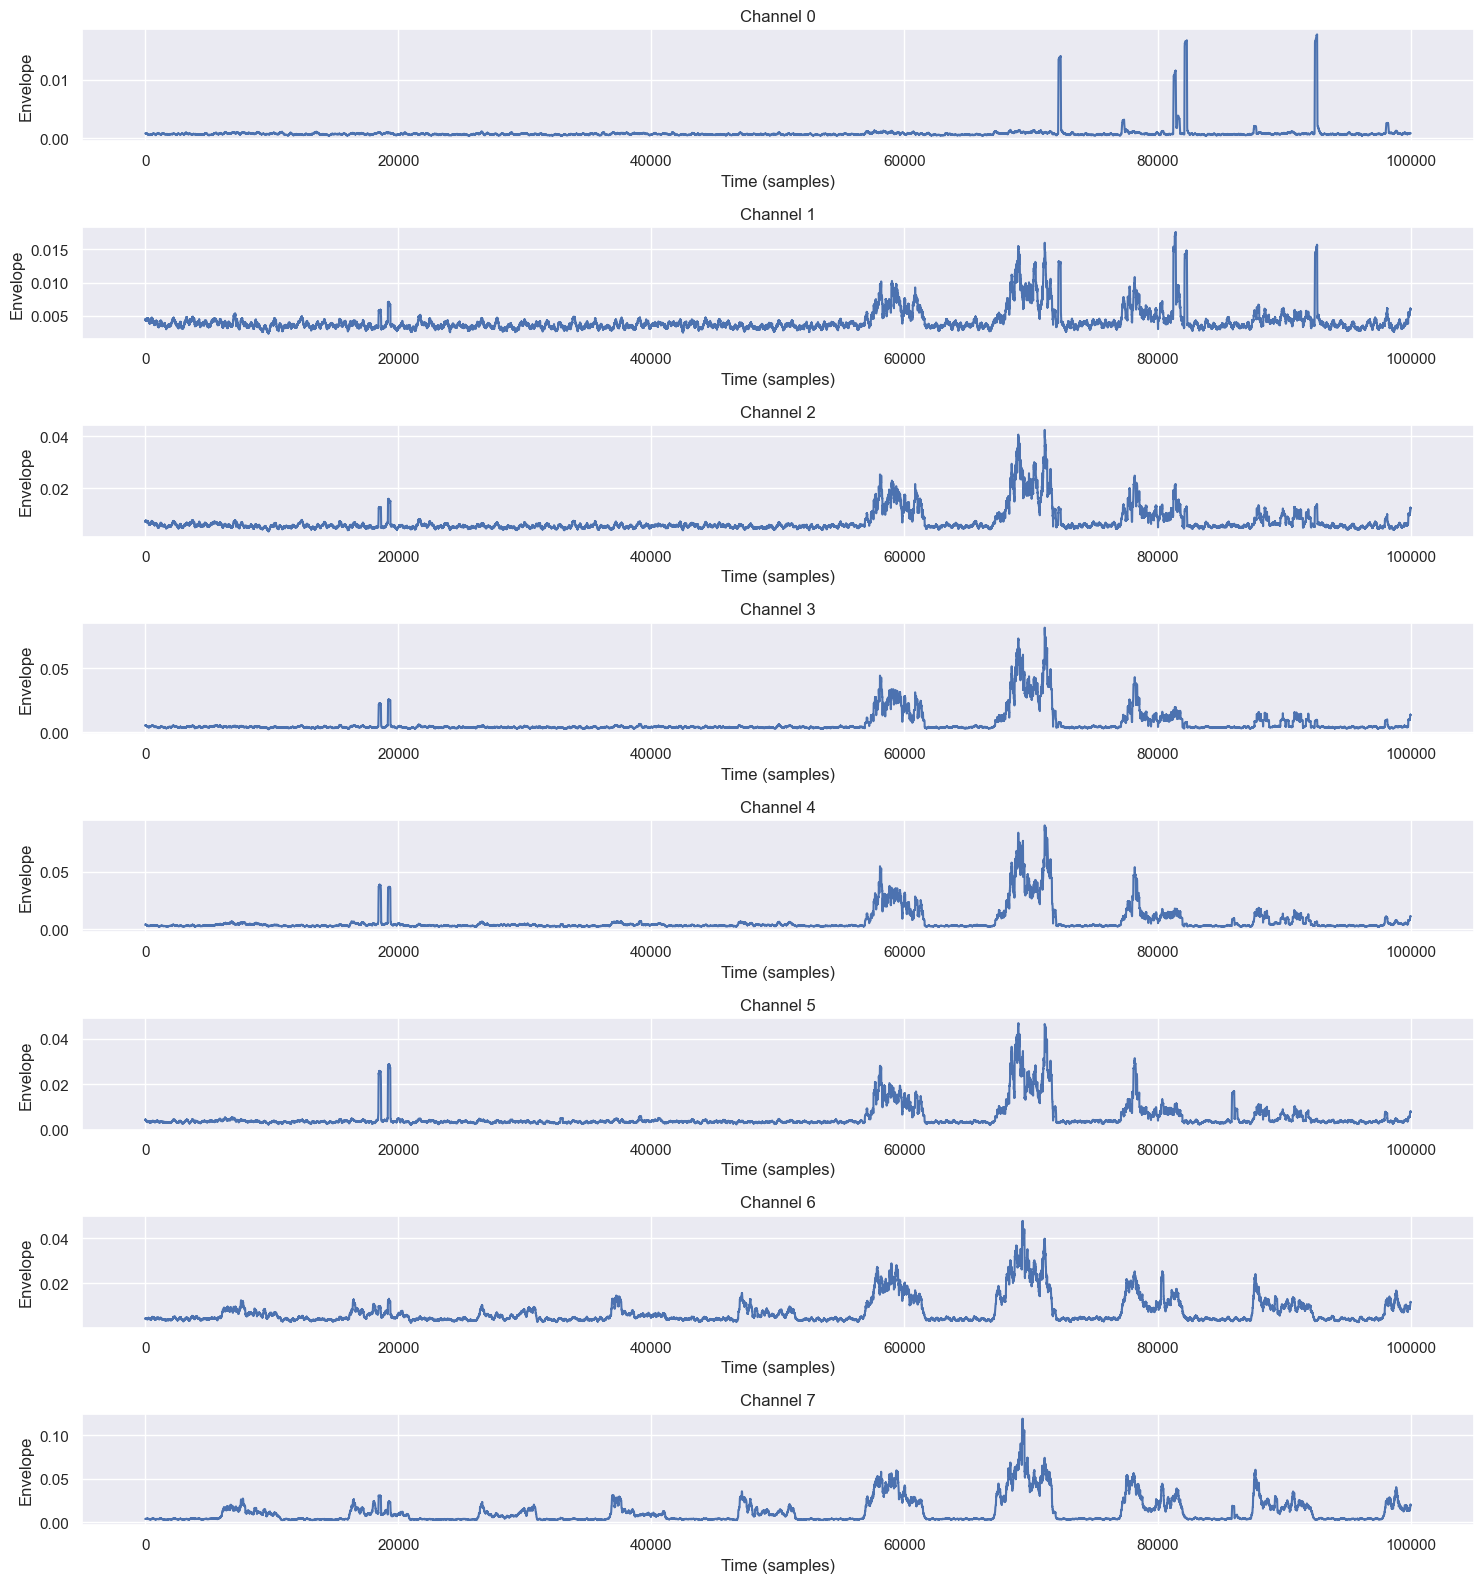

In [8]:
#lets take a quick look at the data

fig, ax = plt.subplots(8, 1, figsize=(15, 16))
for i in range(8):
    ax[i].plot(emg_envelope_200[:100000, i])
    ax[i].set_title("Channel {}".format(i))
    ax[i].set_xlabel("Time (samples)")
    ax[i].set_ylabel("Envelope")

plt.tight_layout()

# NMF for synergy

In [7]:
from sklearn.decomposition import NMF
from tqdm.notebook import tqdm

# For now lets just use 3 components for visualization purposes

nmf = NMF(n_components=(3), init="nndsvda", max_iter=500)

t = time.time()
nmf.fit(emg_envelope_200)
print("Elapsed time: ", time.time() - t)

W = nmf.fit_transform(emg_envelope_200)
H = nmf.components_





Elapsed time:  14.833110570907593


In [9]:
print(W.shape)
print(H.shape)

(1500000, 3)
(3, 64)


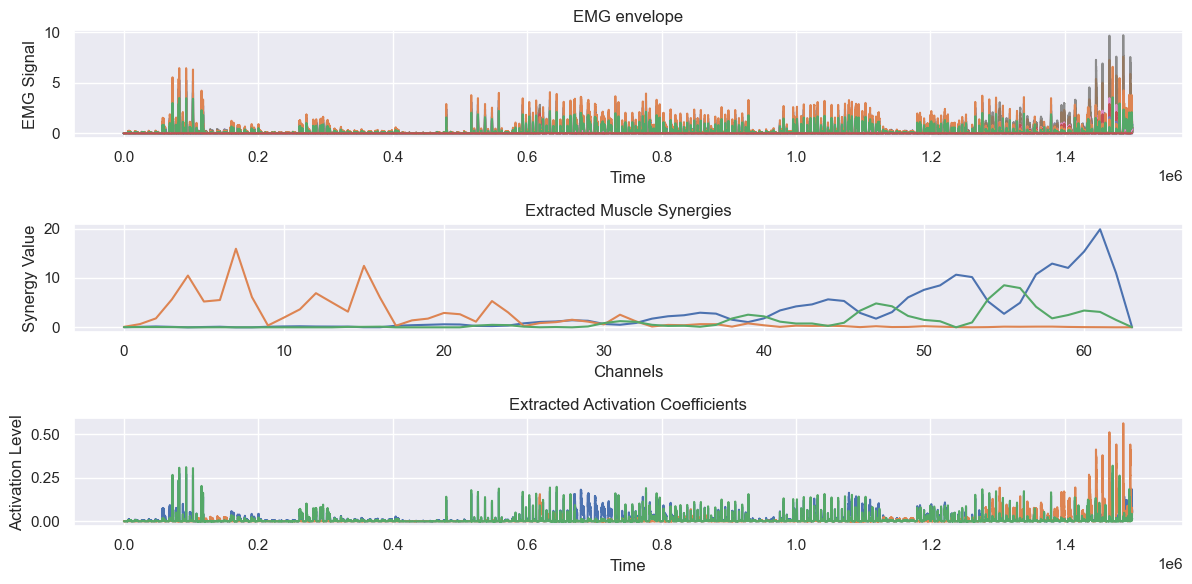

In [8]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_envelope_200)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

The first plot shows the EMG envelop. This data is a mixture of muscle synergies over time across different EMG channels.

The second plot displays the synergies as extracted by the NMF. Each line represents one synergy and how it contributes to each EMG channel.

he third plot illustrates the activation coefficients over time. These coefficients indicate when and how strongly each synergy is activated throughout the dataset.

Observing the generated plots, we notice distinct patterns in the muscle synergies' distribution and activation. The orange synergy predominantly influences the initial half of the EMG channels, whereas the blue synergy appears more significantly in the latter half. In terms of activation timing, the orange synergy exhibits primary activation towards the end of the time period. In contrast, the blue synergy demonstrates a more pronounced activation around the midpoint. Notably, the green synergy, which was not previously mentioned, shows a consistent level of activation throughout the entire duration. This consistent activation suggests a more fundamental role of the green synergy in the overall muscle function.

### Reconstruction error
Moving forward, we will explore the difference in reconstruction error associated with varying the number of components in Non-negative Matrix Factorization (NMF). This analysis will help us understand the impact of different component counts on the accuracy and fidelity of the NMF model in representing the original EMG data.

In [10]:
reconstruction_err_200 = np.zeros(9)

# we will do NMF with 2 to 10 components
for i in range(9):
    print("Running NMF with {} components".format(i + 2))
          
    nmf = NMF(n_components=(i + 2), init="nndsvda", max_iter=500)

    t = time.time()
    nmf.fit(emg_envelope_200)
    print("Elapsed time: ", time.time() - t)

    reconstruction_err_200[i] = nmf.reconstruction_err_

Running NMF with 2 components
Elapsed time:  8.152067184448242
Running NMF with 3 components
Elapsed time:  14.889557361602783
Running NMF with 4 components
Elapsed time:  17.799406051635742
Running NMF with 5 components
Elapsed time:  28.33516764640808
Running NMF with 6 components
Elapsed time:  30.249887943267822
Running NMF with 7 components


c:\ProgramData\Anaconda3\envs\goldin_3090\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  96.05656552314758
Running NMF with 8 components
Elapsed time:  79.47420001029968
Running NMF with 9 components


c:\ProgramData\Anaconda3\envs\goldin_3090\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  134.8742904663086
Running NMF with 10 components


c:\ProgramData\Anaconda3\envs\goldin_3090\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  155.18779277801514


We can also vary the parameters of the envelop to see how it can affect the NMF. This can illustrate how using different preprocessing pipeline can affect the synergy of NMF

In [11]:
weights = np.ones(100)
t = time.time()
emg_envelope_100 = convolve1d(emg_rectified, weights=weights, axis=0)
print("Elapsed time: ", time.time() - t)

Elapsed time:  8.807167768478394


In [12]:
reconstruction_err_100 = np.zeros(9)
for i in range(9):
    nmf = NMF(n_components=(i + 2), init="nndsvda", max_iter=500)

    t = time.time()
    nmf.fit(emg_envelope_100)
    print("Elapsed time: ", time.time() - t)

    reconstruction_err_100[i] = nmf.reconstruction_err_

Elapsed time:  7.313538551330566
Elapsed time:  21.758367776870728
Elapsed time:  24.088438749313354
Elapsed time:  53.76741814613342
Elapsed time:  63.70030856132507
Elapsed time:  95.86328268051147


c:\ProgramData\Anaconda3\envs\goldin_3090\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  112.8793363571167


c:\ProgramData\Anaconda3\envs\goldin_3090\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  133.65382528305054


c:\ProgramData\Anaconda3\envs\goldin_3090\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  151.91127753257751


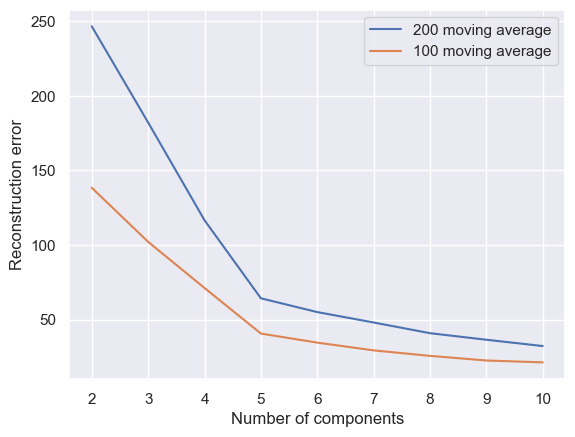

In [16]:
#lets plot the reconstruction error

fig, ax = plt.subplots()
ax.plot(np.arange(2, 11), reconstruction_err_200, label="200 moving average")
ax.plot(np.arange(2, 11), reconstruction_err_100, label="100 moving average")
ax.set_xlabel("Number of components")
ax.set_ylabel("Reconstruction error")
ax.legend()

